# Simple Linear Model on MNIST Dataset
DeepNet Dojo
San Wong (hswong1@uci.edu)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

## Download MNIST Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("../data/MNIST/", one_hot=True)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


## One-Hot Encoding

In [3]:
data.test.labels[0:5,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [4]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
data.test.cls[0:5] #Class

array([7, 2, 1, 0, 4])

## Data Dimension

In [5]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

In [6]:
def plot_images(images,cls_true,cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # fig : matplotlib.figure.Figure object
    # ax : Axes object or array of Axes objects
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i],cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        #Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


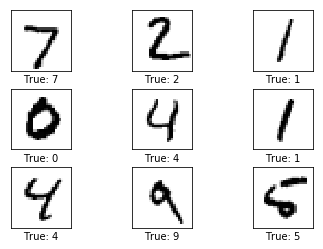

In [7]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images,cls_true=cls_true)

Tensorflow
(1) Placeholder variables used to change the input to the graph.
(2) Model variables that are going to be optimized so as to make the model perform better.
(3) Model, which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
(4) A cost measure that can be used to guide the optimization of the variables.
(5) An optimization method which updates the variables of the model.

## Define Placeholder 

In [8]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
# y_true is a vector that carries the label
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

In [9]:
weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))

In [10]:
biases = tf.Variable(tf.zeros([num_classes]))

In [11]:
logits = tf.matmul(x,weights) + biases

In [12]:
y_pred = tf.nn.softmax(logits)

The predicted class is calculated from the y_pred matrix and takes the index of the largest element in each row

In [13]:
y_pred_cls = tf.argmax(y_pred, axis = 1)

## Define Cost-Function

The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. Therefore, the goal is to minimize the Cross-Entrop

In [14]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y_true)

In [15]:
cost = tf.reduce_mean(cross_entropy)

## Define Optimizer

In [16]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

In [17]:
correct_pred = tf.equal(y_pred_cls, y_true_cls)

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

## Create Tensorflow Session

In [23]:
session = tf.Session()

In [24]:
session.run(tf.global_variables_initializer())

In [25]:
batch_size = 100

Define optimize function. This is the function that run the session for num_iterations and feed in data

In [26]:
def optimize (num_iterations):
    for i in range(num_iterations):
        # Get a new batch
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Define data feed dictionary
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        session.run(optimizer, feed_dict = feed_dict_train)

In [27]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

In [28]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict = feed_dict_test)
    print("Accuracy on Test-Set: {0:.1%}".format(acc))

In [29]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [30]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_pred, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

We don't usually plot weight coz there are a lot of parameters in a network. However, in this simply network, we can visualize each weight and see what they detect in images

In [31]:
def plot_weights():
    # Recall that weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

In [32]:
print_accuracy()

Accuracy on Test-Set: 9.8%


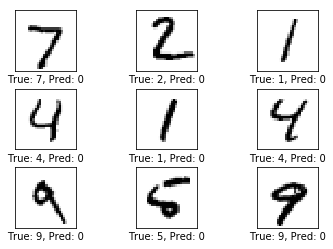

In [33]:
plot_example_errors()

## Run for 10 Iterations

In [34]:
optimize(num_iterations=9)

In [35]:
print_accuracy()

Accuracy on Test-Set: 73.4%


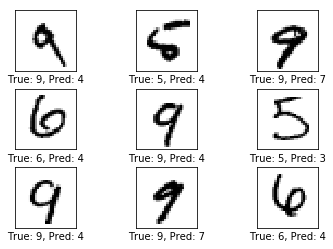

In [36]:
plot_example_errors()

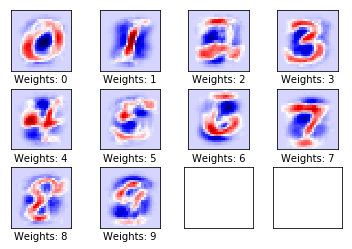

In [37]:
plot_weights()

## Run for 1000 Iterations

In [38]:
optimize(num_iterations=990)


In [39]:
print_accuracy()

Accuracy on Test-Set: 91.9%


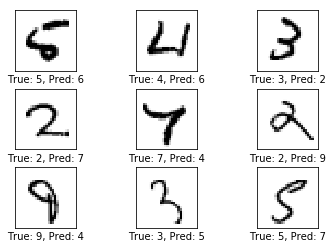

In [40]:
plot_example_errors()

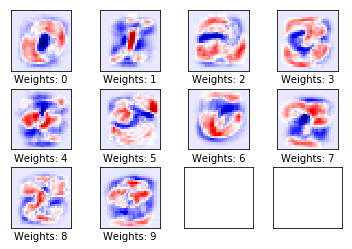

In [41]:
plot_weights()

[[ 961    0    3    2    0    2    9    1    2    0]
 [   0 1095    3    3    0    1    4    2   27    0]
 [  11    3  923   10    9    2   14   12   42    6]
 [   3    0   28  906    0   23    3   17   24    6]
 [   1    1    4    1  911    0   15    3   11   35]
 [  11    3    5   38    9  747   18   10   44    7]
 [  13    3    5    1    9    8  913    2    4    0]
 [   3    5   23    5    5    1    0  960    4   22]
 [  10    3    7   17    9   20   13   13  877    5]
 [  11    4    2    9   32    6    0   31   13  901]]


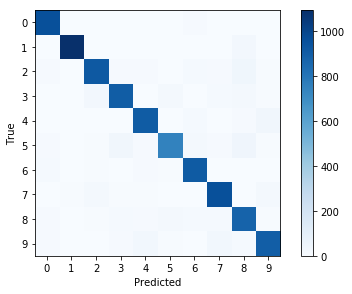

In [42]:
print_confusion_matrix()